In [1]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras
from keras.utils import to_categorical
from keras.models import Sequential,Model
from keras.layers import Dense,Input,BatchNormalization,LeakyReLU, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [ ]:
#Leemos las imagenes

from multiprocessing.resource_sharer import stop


imgpath = 'SampleImages/sportimages/'

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0

dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

In [4]:
#PONEMOS ETIQUETAS A CADA TIPO DE IMAGEN PARA EL ENTRENAMIENTO SUPERVISADO
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))

deportes=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    deportes.append(name[len(name)-1])
    indice=indice+1

y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy

# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Cantidad etiquetas creadas:  77128
0 americano
1 basket
2 beisball
3 boxeo
4 ciclismo
5 f1
6 futbol
7 golf
8 natacion
9 tenis
Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


In [5]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

Training data shape :  (61702, 21, 28, 3) (61702,)
Testing data shape :  (15426, 21, 28, 3) (15426,)
Original label: 4
After conversion to one-hot: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
(49361, 21, 28, 3) (12341, 21, 28, 3) (49361, 10) (12341, 10)


In [6]:
INIT_LR = 1e-3
epochs = 6
batch_size = 64

sport_model = Sequential()
sport_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(21,28,3)))#Definimos las dimensiones de entrada
sport_model.add(LeakyReLU(alpha=0.1))#Funcion de activacion
sport_model.add(MaxPooling2D((2, 2),padding='same'))
sport_model.add(Dropout(0.5))

sport_model.add(Flatten())
sport_model.add(Dense(32, activation='linear'))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(Dropout(0.5)) 
sport_model.add(Dense(nClasses, activation='softmax'))

sport_model.summary()

sport_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adagrad(learning_rate=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 21, 28, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 21, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 11, 14, 32)        0         
                                                                 
 flatten (Flatten)           (None, 4928)              0         
                                                                 
 dense (Dense)               (None, 32)                157728    
                                                        

In [7]:
#sport_train_dropout = sport_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))
sport_train = sport_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
sport_model.save("sports_mnist.h5py")

Epoch 1/6
772/772 [==============================] - 18s 22ms/step - loss: 2.1900 - accuracy: 0.1948 - val_loss: 1.9742 - val_accuracy: 0.4522
Epoch 2/6
772/772 [==============================] - 17s 22ms/step - loss: 1.9181 - accuracy: 0.3424 - val_loss: 1.6306 - val_accuracy: 0.5764
Epoch 3/6
772/772 [==============================] - 17s 22ms/step - loss: 1.6954 - accuracy: 0.4244 - val_loss: 1.4063 - val_accuracy: 0.6629
Epoch 4/6
772/772 [==============================] - 17s 22ms/step - loss: 1.5477 - accuracy: 0.4720 - val_loss: 1.2626 - val_accuracy: 0.6880
Epoch 5/6
772/772 [==============================] - 17s 22ms/step - loss: 1.4438 - accuracy: 0.5111 - val_loss: 1.1645 - val_accuracy: 0.7110
Epoch 6/6
772/772 [==============================] - 17s 22ms/step - loss: 1.3691 - accuracy: 0.5357 - val_loss: 1.0862 - val_accuracy: 0.7244


INFO:tensorflow:Assets written to: sports_mnist.h5py\assets


INFO:tensorflow:Assets written to: sports_mnist.h5py\assets


In [8]:
test_eval = sport_model.evaluate(test_X, test_Y_one_hot, verbose=1)

print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

483/483 [==============================] - 2s 4ms/step - loss: 1.0883 - accuracy: 0.7203
Test loss: 1.0882662534713745
Test accuracy: 0.7203422784805298


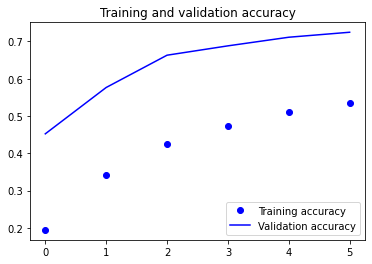

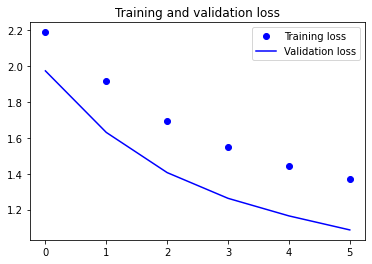

In [9]:
accuracy = sport_train.history['accuracy']
val_accuracy = sport_train.history['val_accuracy']
loss = sport_train.history['loss']
val_loss = sport_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [10]:
predicted_classes2 = sport_model.predict(test_X)

483/483 [==============================] - 2s 4ms/step


In [11]:
predicted_classes=[]
for predicted_sport in predicted_classes2:
    predicted_classes.append(predicted_sport.tolist().index(max(predicted_sport)))
predicted_classes=np.array(predicted_classes)

In [12]:
predicted_classes.shape, test_Y.shape

((15426,), (15426,))

Found 11112 correct labels


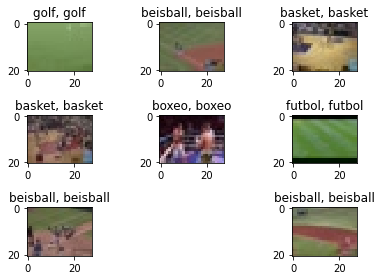

In [13]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[correct]],
                                                    deportes[test_Y[correct]]))

    plt.tight_layout()

Found 4314 incorrect labels


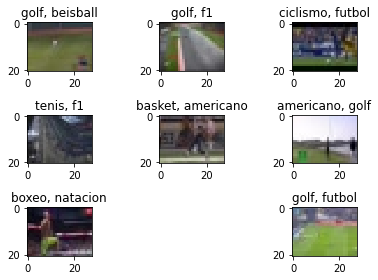

In [14]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(21,28,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[incorrect]],
                                                    deportes[test_Y[incorrect]]))
    plt.tight_layout()

In [15]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.60      0.38      0.47      1923
     Class 1       0.68      0.75      0.71      1769
     Class 2       0.69      0.78      0.73      1528
     Class 3       0.70      0.85      0.77      1429
     Class 4       0.95      0.98      0.97      1541
     Class 5       0.82      0.20      0.32      1026
     Class 6       0.78      0.62      0.69      1442
     Class 7       0.51      0.75      0.60      1967
     Class 8       0.90      0.77      0.83      1016
     Class 9       0.88      1.00      0.94      1785

    accuracy                           0.72     15426
   macro avg       0.75      0.71      0.70     15426
weighted avg       0.73      0.72      0.71     15426



In [56]:
from skimage.transform import resize

images=[]
# AQUI ESPECIFICAMOS UNAS IMAGENES
filenames = ['SampleImages/ame.jpg']

#for filepath in filenames:
image = plt.imread(filenames[0],0)
image_resized = resize(image, (21, 28),anti_aliasing=True,clip=False,preserve_range=True)
images.append(image_resized)

1/1 [==============================] - 0s 32ms/step
SampleImages/ame.jpg golf


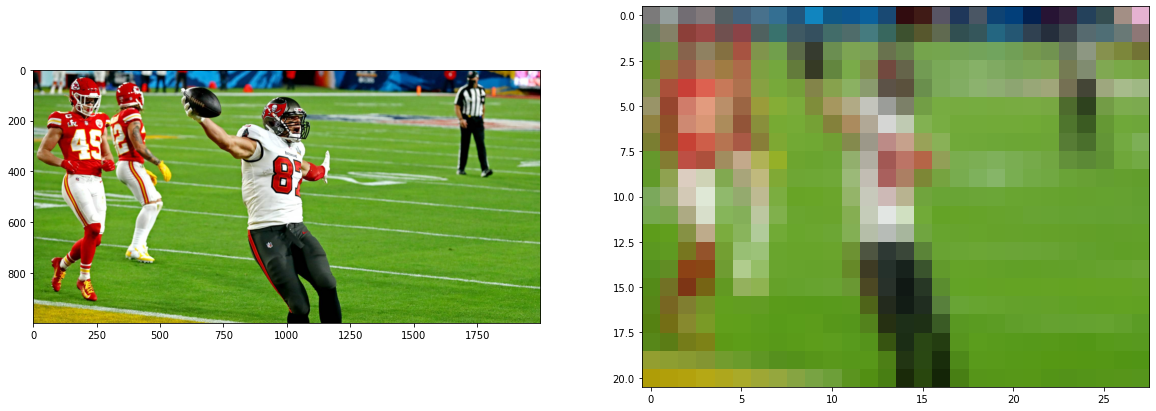

In [57]:

X = np.array(images, dtype=np.uint8) #convierto de lista a numpy
test_X = X.astype('float32')
test_X = test_X / 255.
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,20))
ax[0].imshow(image)
ax[1].imshow(X[0])
plt.show
predicted_classes = sport_model.predict(test_X)

for i, img_tagged in enumerate(predicted_classes):
    print(filenames[i], deportes[img_tagged.tolist().index(max(img_tagged))])